In [1]:
import jax
import jax.numpy as jnp
import jax.random as random
import numpyro
from numpyro.infer import Predictive
from numpyro.infer.util import log_density, log_likelihood
import pandas as pd
import dill
import matplotlib.pyplot as plt
import os
import sys
import arviz as az
from tqdm.notebook import tqdm
# Add ../code to PYTHON_PATH
sys.path.insert(0, "../code")
sys.path.insert(0, "..")
import bnns.model_configs
from datasets.ecg import ECGDataset
jax.config.update("jax_enable_x64", True)
plt.style.use("seaborn-v0_8-whitegrid")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
SAMPLE_PATH = "../samples/ecg-5"
SEED = 10

In [5]:
methods = [d for d in os.listdir(SAMPLE_PATH) if os.path.isdir(os.path.join(SAMPLE_PATH, d))]
dataset = ECGDataset(resample_train=False)

def load_samples():
    methods = os.listdir(SAMPLE_PATH)
    samples = []
    for method in methods:
        path = os.path.join(SAMPLE_PATH, method, "ecg")
        if method == "SVI":
            splits = os.listdir(path)
            for split in splits:
                with open(os.path.join(path, split), "rb") as f:
                    svi_result = dill.load(f)
                model_name = "_".join(split.split(".")[0].split("_")[:-1])
                split_ind = split.split(".")[0].split("_")[-1]
                model = getattr(bnns.model_configs, model_name)
                params = svi_result["params"]
                guide = svi_result["guide"]
                predictive = Predictive(guide, params=params, num_samples=1)
                post_draws = predictive(jax.random.PRNGKey(SEED), None)
                samples.append({
                    "model": model,
                    "method": method,
                    "model": model_name,
                    "split": split_ind,
                    "post_draws": post_draws
                })
        if method == "HMC":
            splits = os.listdir(path)
            for split in splits:
                if ".nc" not in split:
                    continue
                inference_data = az.from_netcdf(os.path.join(path, split))
                model_name = "_".join(split.split(".")[0].split("_")[:-1])
                split_ind = split.split(".")[0].split("_")[-1]
                model = getattr(bnns.model_configs, model_name)

                post_draws = inference_data.to_dict()["posterior"]
                post_draws.pop("y_probs", None)

                with open(os.path.join(path, split.replace(".nc", "_metadata.dill")), "rb") as f:
                    metadata = dill.load(f)
                samples.append({
                    "model": model,
                    "method": method,
                    "model": model_name,
                    "split": split_ind,
                    "post_draws": post_draws,
                    "inference_data": inference_data,
                    "time_spanned": metadata["time_spanned"],
                    "accept_prob": metadata["accept_prob"],
                    "step_size": metadata["adapt_state.step_size"],
                    "num_steps": metadata["num_steps"],
                })
    return samples
samples = load_samples()

In [ ]:
from numpyro.infer import log_likelihood
from sklearn.utils import resample

def evaluate(model, post_draws, X, y, batch_ndims, adjust=True):
    predictive = Predictive(model, post_draws, batch_ndims=batch_ndims)
    if adjust:
        prior_probs = dataset.train_label_distribution()
    else:
        prior_probs = None
    predictions = predictive(jax.random.PRNGKey(SEED), X, prior_probs=prior_probs)["y_probs"]

    y_pred = jnp.argmax(predictions, -1)[0]
    assert y.shape[-1] == y_pred.shape[-1], f"y_test shape: {y.shape}, y_pred shape: {y_pred.shape}"
    return y_pred, predictions

def batch_nll(model, post_draws, X, y, batch_ndims, adjust=True):
    batch_size = min(5120, X.shape[0])
    n_batches = X.shape[0] // batch_size + 1 if X.shape[0] > 5120 else 1
    nlls = []
    if adjust:
        prior_probs = dataset.train_label_distribution()
    else:
        prior_probs = None

    for i in range(n_batches):
        start = i * batch_size
        end = max((i + 1) * batch_size, X.shape[0] - 1)
        nll = log_likelihood(model, post_draws, X[start:end], y[start:end], prior_probs=prior_probs, batch_ndims=batch_ndims)["y"]
        #nll = jax.scipy.special.logsumexp(nll, axis=-2) - jnp.log(nll.shape[-2])
        if batch_ndims == 2:
            nll = jax.scipy.special.logsumexp(nll, axis=-2).astype(jnp.float64) - jnp.log(nll.shape[-2])
        nlls.append(nll)
    nlls = jnp.concat(nlls, axis=-1)
    nlls = jax.scipy.special.logsumexp(nlls, axis=-2)
    return -jnp.mean(nlls.astype(jnp.float64)).astype(jnp.float64), jnp.std(nlls.astype(jnp.float64)).astype(jnp.float64)


Array([0.00096225, 0.00096225, 0.00096225, ..., 0.00096225, 0.00096225,
       0.00096225], dtype=float32)

In [ ]:
results = []
preds = []
for sample_dict in tqdm(samples):
    method = sample_dict["method"]
    model = getattr(bnns.model_configs, sample_dict["model"])
    post_draws = sample_dict["post_draws"].copy()
    batch_ndims = 1 if sample_dict["method"] == "SVI" else 2

    split = dataset.splits[int(sample_dict["split"])]
    X = dataset.normalize_X(dataset.X, split)

    X_train = X[split["tr"]]
    y_train = dataset.y[split["tr"]]

    X_test = X[split["te"]]
    y_test = dataset.y[split["te"]]

    # Get subset for testing
    X_train, y_train = resample(X_train, y_train, n_samples=300, random_state=SEED)
    X_test, y_test = resample(X_test, y_test, n_samples=300, random_state=SEED)

    train_nll, train_nll_std = batch_nll(model, post_draws, X_train, y_train, batch_ndims, adjust=False)
    test_nll, test_nll_std = batch_nll(model, post_draws, X_test, y_test, batch_ndims, adjust=False)

    y_pred_train, y_pred_train_probs = evaluate(model, post_draws, X_train, y_train, batch_ndims, adjust=False)
    train_accuracy = (y_train == y_pred_train).mean()
    train_accuracy_std = (y_train == y_pred_train).std()

    #y_pred_test, y_pred_test_probs = evaluate(model, post_draws, X_test, y_test, batch_ndims, adjust=True)
    y_pred_test_unadjusted, y_pred_test_probs_unadjusted = evaluate(model, post_draws, X_test, y_test, batch_ndims, adjust=False)
    #test_accuracy = (y_test == y_pred_test).mean()
    test_accuracy_unadjusted = (y_test == y_pred_test_unadjusted).mean()
    test_accuracy_unadjusted_std = (y_test == y_pred_test_unadjusted).std()


    if method == "HMC":
        if "Spectral" in sample_dict["model"]:
            for i in range(len([key in post_draws for key in post_draws.keys() if "w_hat" in key])):
                post_draws.pop(f"w_hat_{i}", None)
        summary = numpyro.diagnostics.summary(post_draws)

        ess = jnp.array([jnp.nanmean(value["n_eff"]) for _, value in summary.items()])
        rhat = jnp.array([jnp.nanmean(value["r_hat"]) for _, value in summary.items()])
        time_spanned = sample_dict.get("time_spanned", None)
        accept_prob = sample_dict.get("accept_prob", None)
        ess_per_s = ess / time_spanned
    else:
        ess = jnp.nan
        rhat = jnp.nan
        time_spanned = jnp.nan
        accept_prob = jnp.nan
        ess_per_s = jnp.nan

    results.append({
        "method": sample_dict["method"],
        "model": sample_dict["model"],
        "split": sample_dict["split"],
        "train_nll": train_nll.mean(),
        "test_nll": test_nll.mean(),
        "train accuracy": f"{train_accuracy * 100 : .3f}%",
        "train accuracy std": f"{train_accuracy_std * 100 : .3f}%",
        #"test accuracy": f"{test_accuracy * 100 : .3f}%",
        "test accuracy, udadjusted": f"{test_accuracy_unadjusted * 100 : .3f}%",
        "test accuracy, udadjusted std": f"{test_accuracy_unadjusted_std * 100 : .3f}%",
        "ess": ess.mean(),
        "ess_std": ess.std(),
        "rhat": rhat.mean(),
        "rhat_std": rhat.std(),
        "time_spanned": time_spanned,
        "accept_prob": accept_prob.mean(),
        "ess_per_s": ess_per_s.mean(),
        "ess_per_s_std": ess_per_s.std()
    })
    preds.append({
        "y_train": y_train,
        "y_pred_train": y_pred_train,
        "y_pred_train_probs": y_pred_train_probs,
        "y_test": y_test,
        #"y_pred_test": y_pred_test,
        "y_pred_test_unadjusted": y_pred_test_unadjusted,
        #"y_pred_test_probs": y_pred_test_probs,
        "y_pred_test_probs_unadjusted": y_pred_test_probs_unadjusted
    })
results = pd.DataFrame(results)
results
    

  0%|          | 0/3 [00:00<?, ?it/s]

,method,model,split,train_nll,test_nll,train accuracy,train accuracy std,"test accuracy, udadjusted","test accuracy, udadjusted std",ess,ess_std,rhat,rhat_std,time_spanned,accept_prob,ess_per_s,ess_per_s_std
0,HMC,ECG_BNN_128,0,0.024414155207843742,0.5285355071756119,99.000%,9.950%,95.972%,19.660%,5.799833826468927,0.6335093287643112,1.6400131,0.040272817,9127.742582,0.83061165,0.0006354072515153057,6.940481976610538e-05
1,HMC,ECG_CBNN_tanh_128,0,0.07321825286826987,0.09054018662115598,98.380%,12.624%,96.930%,17.249%,72.23794466519206,113.29960975329696,1.2517238,0.12815125,23794.661297,0.81506056,0.0030358887551825775,0.004761555894354625
2,HMC,ECG_Spectral_BNN_tanh_128,0,0.06390127295078862,0.11469199232649961,98.043%,13.853%,96.525%,18.314%,62.76968609958288,38.100930205602424,1.0627027,0.0449641,21048.225810,0.851876,0.002982184183376541,0.0018101730069323401


In [8]:
sample_dict["post_draws"]["b0"].shape
preds

[{'y_train': Array([2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 4., 4., 0., 0., 2., 2., 0., 0., 0.,
         0., 0., 0., 0., 4., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0.,
         0., 4., 2., 0., 0., 0., 0., 4., 2., 0., 0., 0., 0., 0., 4., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 2., 0., 0., 0., 0., 4., 2.,
         0., 0., 0., 0., 0., 3., 0., 4., 0., 0., 0., 0., 0., 0., 0.],      dtype=float64),
  'y_pred_train': Array([[2, 0, 0, ..., 0, 0, 0],
         [2, 0, 0, ..., 0, 0, 0],
         [2, 0, 0, ..., 0, 0, 0],
         ...,
         [2, 0, 0, ..., 0, 0, 0],
         [2, 0, 0, ..., 0, 0, 0],
         [2, 0, 0, ..., 0, 0, 0]], dtype=int64),
  'y_pred_train_probs': Array([[[[-15.13268752,  -1.13060857,  34.89215776,   8.21694621,
            -14.85874596],
           [ 40.30948008,   5.37876321, -10.56025941, -14.53369402,
            -16.73276064],
           [ 40.24748073,  -6.57637161, -18.44608545

# Produce final table

In [ ]:
results = []
preds = []
split = dataset.splits[int(sample_dict["split"])]
X = dataset.normalize_X(dataset.X, split)

X_train = X[split["tr"]]
y_train = dataset.y[split["tr"]]

X_test = X[split["te"]]
y_test = dataset.y[split["te"]]

# Get subset for testing
X_train, y_train = resample(X_train, y_train, n_samples=10, random_state=SEED)
X_test, y_test = resample(X_test, y_test, n_samples=10, random_state=SEED)
for sample_dict in tqdm(samples):
    method = sample_dict["method"]
    model = getattr(bnns.model_configs, sample_dict["model"])
    post_draws = sample_dict["post_draws"].copy()
    batch_ndims = 1 if sample_dict["method"] == "SVI" else 2


    train_nll, train_nll_std = batch_nll(model, post_draws, X_train, y_train, batch_ndims, adjust=False)
    test_nll, test_nll_std = batch_nll(model, post_draws, X_test, y_test, batch_ndims, adjust=False)

    y_pred_train, y_pred_train_probs = evaluate(model, post_draws, X_train, y_train, batch_ndims, adjust=False)
    train_accuracy = (y_train == y_pred_train).mean()
    train_accuracy_std = (y_train == y_pred_train).std()

    #y_pred_test, y_pred_test_probs = evaluate(model, post_draws, X_test, y_test, batch_ndims, adjust=True)
    y_pred_test_unadjusted, y_pred_test_probs_unadjusted = evaluate(model, post_draws, X_test, y_test, batch_ndims, adjust=False)
    #test_accuracy = (y_test == y_pred_test).mean()
    test_accuracy_unadjusted = (y_test == y_pred_test_unadjusted).mean()
    test_accuracy_unadjusted_std = (y_test == y_pred_test_unadjusted).std()


    if method == "HMC":
        if "Spectral" in sample_dict["model"]:
            for i in range(len([key in post_draws for key in post_draws.keys() if "w_hat" in key])):
                post_draws.pop(f"w_hat_{i}", None)
        summary = numpyro.diagnostics.summary(post_draws)

        ess = jnp.array([jnp.nanmean(value["n_eff"]) for _, value in summary.items()])
        rhat = jnp.array([jnp.nanmean(value["r_hat"]) for _, value in summary.items()])
        time_spanned = sample_dict.get("time_spanned", None)
        accept_prob = sample_dict.get("accept_prob", None)
        ess_per_s = ess / time_spanned
    else:
        ess = jnp.nan
        rhat = jnp.nan
        time_spanned = jnp.nan
        accept_prob = jnp.nan
        ess_per_s = jnp.nan

    results.append({
        "method": sample_dict["method"],
        "model": sample_dict["model"],
        "split": sample_dict["split"],
        "train_nll": train_nll.mean(),
        "test_nll": test_nll.mean(),
        "train accuracy": f"{train_accuracy * 100 : .3f}%",
        "train accuracy std": f"{train_accuracy_std * 100 : .3f}%",
        #"test accuracy": f"{test_accuracy * 100 : .3f}%",
        "test accuracy, udadjusted": f"{test_accuracy_unadjusted * 100 : .3f}%",
        "test accuracy, udadjusted std": f"{test_accuracy_unadjusted_std * 100 : .3f}%",
        "ess": ess.mean(),
        "ess_std": ess.std(),
        "rhat": rhat.mean(),
        "rhat_std": rhat.std(),
        "time_spanned": time_spanned,
        "accept_prob": accept_prob.mean(),
        "ess_per_s": ess_per_s.mean(),
        "ess_per_s_std": ess_per_s.std()
    })
    preds.append({
        "y_train": y_train,
        "y_pred_train": y_pred_train,
        "y_pred_train_probs": y_pred_train_probs,
        "y_test": y_test,
        #"y_pred_test": y_pred_test,
        "y_pred_test_unadjusted": y_pred_test_unadjusted,
        #"y_pred_test_probs": y_pred_test_probs,
        "y_pred_test_probs_unadjusted": y_pred_test_probs_unadjusted
    })
results = pd.DataFrame(results)
results

In [32]:
sample_dict = samples[1]
model = getattr(bnns.model_configs, sample_dict["model"])
post_draws = sample_dict["post_draws"]
batch_nll(model, post_draws, X_test, y_test, batch_ndims, adjust=True)

IndexError: list index out of range

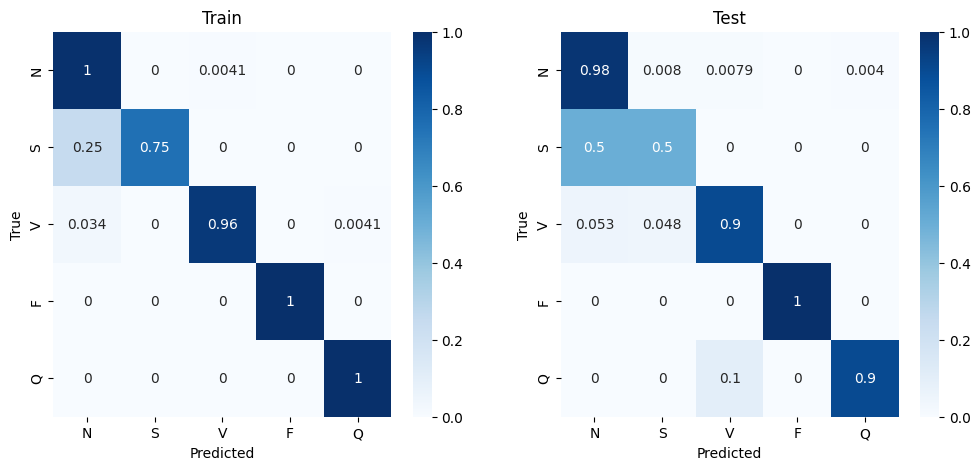

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

index = 0
labels = ["N", "S", "V", "F", "Q"]

train_y = preds[index]["y_train"]
y_pred_train = preds[index]["y_pred_train"].flatten()
train_y_repeated = jnp.tile(train_y, y_pred_train.shape[0] // train_y.shape[0])

test_y = preds[index]["y_test"]
y_pred_test = preds[index]["y_pred_test_unadjusted"].flatten()
test_y_repeated = jnp.tile(test_y, y_pred_test.shape[0] // test_y.shape[0])

cm_train = confusion_matrix(train_y_repeated.astype(jnp.int64), y_pred_train, normalize="true")
cm_test = confusion_matrix(test_y_repeated.astype(jnp.int64), y_pred_test, normalize="true")

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_train, ax=axs[0], annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')
axs[0].set_title('Train')
# sns.heatmap(cm_test, ax=axs[1], annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
# axs[1].set_xlabel('Predicted')
# axs[1].set_ylabel('True')
# axs[1].set_title('Test confusion Matrix')
sns.heatmap(cm_test, ax=axs[1], annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')
axs[1].set_title('Test')
plt.show()

/tmp/ipykernel_19522/2523752918.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_1.show()
/tmp/ipykernel_19522/2523752918.py:65: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_2.show()


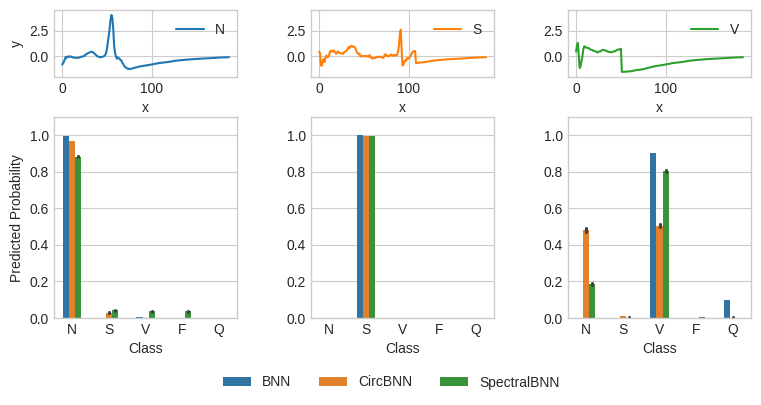

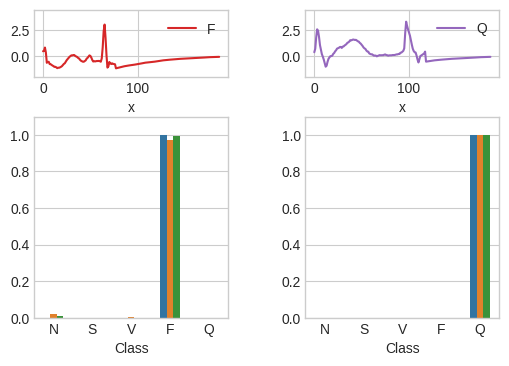

In [79]:
cm = jnp.zeros((5, 5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
#print("Predicted", jnp.exp(y_pred_train_probs[0, :, i]) / total)
N = 10

cherry_picked_indices = []
for i in range(0,5):
    cherry_picked_indices.append(jnp.where(test_y == i)[0][0])

fig_1, axs_1 = plt.subplot_mosaic(
    [["ecg_N", "ecg_S", "ecg_V"], ["predictions_N", "predictions_S", "predictions_V"]], 
    width_ratios=[1, 1, 1],
    height_ratios=[1, 3], 
    figsize=(9, 4),
    )
fig_2, axs_2 = plt.subplot_mosaic(
    [["ecg_F", "ecg_Q"], ["predictions_F", "predictions_Q"]], 
    width_ratios=[1, 1],
    height_ratios=[1, 3], 
    figsize=(6, 4),
    )
ecg_axs = (axs_1["ecg_N"], axs_1["ecg_S"], axs_1["ecg_V"], axs_2["ecg_F"], axs_2["ecg_Q"])
prediction_axs = (axs_1["predictions_N"], axs_1["predictions_S"], axs_1["predictions_V"], axs_2["predictions_F"], axs_2["predictions_Q"])

def fix_name(name):
    if "Spectral" in name:
        return "SpectralBNN"
    if "CBNN" in name:
        return "CircBNN"
    return "BNN"
l = None
ecg_axs[0].set_ylabel("y")
for ax_ind, y_ind in enumerate(cherry_picked_indices):
    #total = jnp.expand_dims(jnp.exp(y_pred_test_probs[0, :, y_ind]).sum(axis=-1), -1)
    #fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(7, 3*5))

    ecg_axs[ax_ind].plot(X_test[y_ind, :], color=colors[int(test_y_repeated[y_ind])], label=labels[int(test_y_repeated[y_ind])])
    ecg_axs[ax_ind].set_xlabel("x")
    ecg_axs[ax_ind].legend()
    ecg_axs[ax_ind].set_ylim(-2, 4.5)
    df = pd.DataFrame(columns=["Model", "Class", "Probability"])
    for pred, sample_dict in zip(preds, samples):
        y_pred_test_probs = jax.nn.softmax(pred["y_pred_test_probs_unadjusted"], axis=-1)
        #y_pred_test_probs = pred["y_pred_test_probs_unadjusted"]
        for c in range(5):
            df = pd.concat([df, pd.DataFrame({
                "Model": fix_name(sample_dict["model"]),
                "Class": labels[c],
                "Predicted Probability": y_pred_test_probs[0, :, y_ind, c]
            })], ignore_index=True)


    sns.barplot(df, x="Class", hue="Model", y="Predicted Probability", ax=prediction_axs[ax_ind], legend=ax_ind == 1, width=0.5)
    if ax_ind == 1:
        h, l = prediction_axs[ax_ind].get_legend_handles_labels()
        prediction_axs[ax_ind].get_legend().remove()
    if ax_ind > 0:
        prediction_axs[ax_ind].set_ylabel("")
    prediction_axs[ax_ind].set_ylim(0, 1.1)
fig_1.subplots_adjust(wspace=0.4, hspace=0.3)
fig_2.subplots_adjust(wspace=0.4, hspace=0.3)
fig_1.legend(h, l, title="", loc="lower center", bbox_to_anchor=(0.50, -0.1), ncol=3, frameon=False)
#sns.move_legend(prediction_axs[1], "lower center", bbox_to_anchor=(0.5, -0.35), ncol=3, title="", frameon=False)
fig_1.show()
fig_2.show()
    # axs[ax_ind, 1].set_xticklabels(labels)
    # axs[ax_ind, 1].set_ylim(0,1.1)
    # y_pred_test_probs = jax.nn.softmax(preds[1]["y_pred_test_probs_unadjusted"])
    # sns.barplot(y_pred_test_probs[0, :, y_ind], ax=axs[ax_ind,2])
    # axs[ax_ind, 2].set_xticklabels(labels)
    # axs[ax_ind, 2].set_ylim(0,1.1)
    # y_pred_test_probs = preds[2]["y_pred_test_probs_unadjusted"]
    # sns.barplot(y_pred_test_probs[0, :, y_ind], ax=axs[ax_ind,3])
    # axs[ax_ind, 3].set_xticklabels(labels)
    # axs[ax_ind, 3].set_ylim(0,1.1)

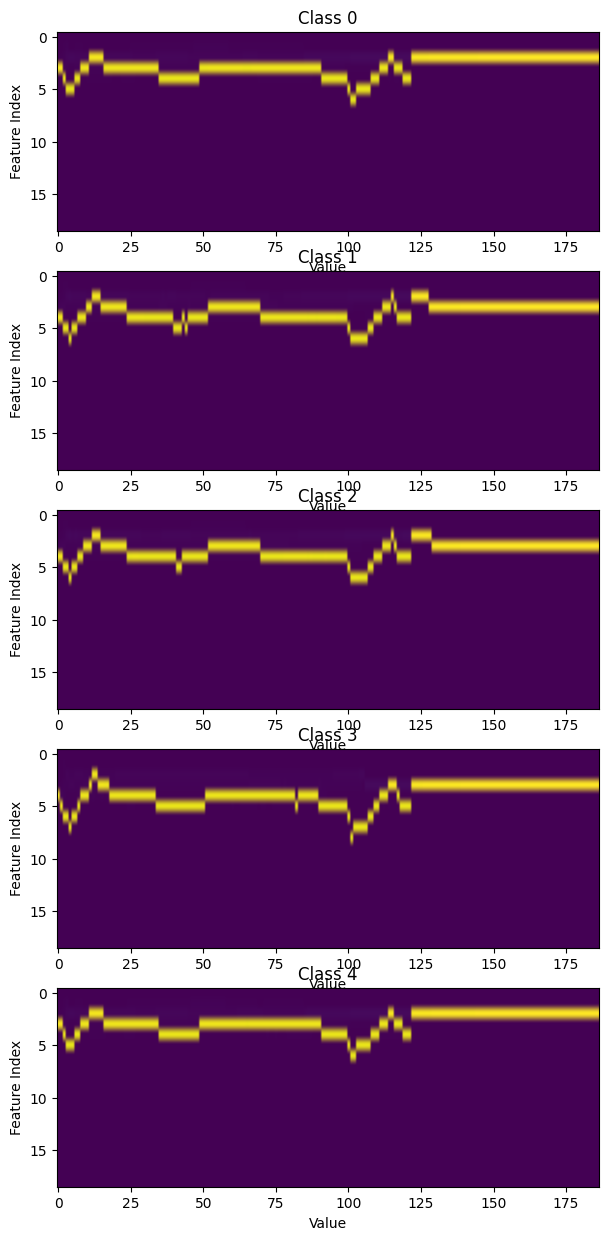

In [ ]:
fig, axs = plt.subplots(ncols=1, nrows=5, figsize=(7, 3*5))
for class_ind in range(5):
    class_indices = jnp.where(test_y_repeated == class_ind)
    Xs = X_test[class_indices]
    columns = []
    bins = jnp.linspace(Xs.min(), Xs.max(), 20)
    for i in range(Xs.shape[1]):
        columns.append(jnp.histogram(Xs[:, i], bins=bins, density=True)[0])
    image = jnp.stack(columns, axis=1)
    axs[class_ind].imshow(image, aspect='auto')
    axs[class_ind].set_title(f"Class {class_ind}")
    axs[class_ind].set_xlabel("Value")
    axs[class_ind].set_ylabel("Feature Index")

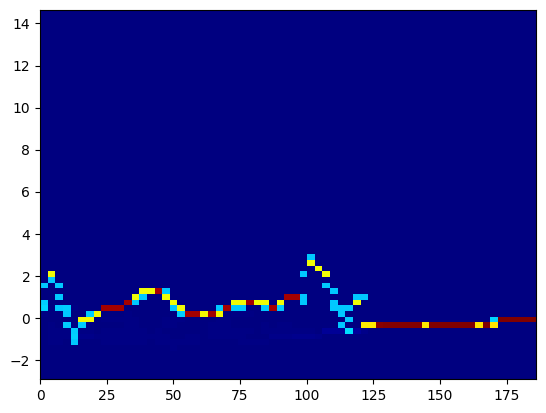

In [62]:
for class_ind in range(1):
    Xs = X_test[jnp.where(test_y_repeated == class_ind)]
    Xs = jnp.stack([Xs, jnp.tile(jnp.arange(Xs.shape[1]), (Xs.shape[0], 1))], axis=0)
    #img = jnp.zeros((jnp.ceil(Xs.max() - Xs.min()).astype(int), Xs.shape[1]))
    #Xs = Xs.flatten()
    plt.hist2d(Xs[1].flatten(), Xs[0].flatten(), bins=(65, 65), density=True, cmap=plt.cm.jet)


In [90]:
# Calculate class distribution
split = dataset.splits[int(sample_dict["split"])]
X = dataset.normalize_X(dataset.X, split)

X_train = X[split["tr"]]
train_y = dataset.y[split["tr"]]

X_test = X[split["te"]]
test_y = dataset.y[split["te"]]
train_class_distribution = jnp.bincount(train_y.astype(int), minlength=5)
test_class_distribution = jnp.bincount(test_y.astype(int), minlength=5)

total_train = train_class_distribution.sum()
total_test = test_class_distribution.sum()
df = pd.DataFrame(columns=["N", "S", "V", "F", "Q"])
df = pd.DataFrame({
    "Train": [str(s) for s in train_class_distribution],
    "Test": [str(s) for s in test_class_distribution],
    "Train, %": [f"{s : .3f} \\%" for s in (train_class_distribution / total_train * 100)],
    "Test, %": [f"{s : .3f} \\%" for s in (test_class_distribution / total_test * 100)]
}, index=["N", "S", "V", "F", "Q"]).T
df

,N,S,V,F,Q
Train,72471,2223,5788,641,6431
Test,18118,556,1448,162,1608
"Train, %",82.773 \%,2.539 \%,6.611 \%,0.732 \%,7.345 \%
"Test, %",82.761 \%,2.540 \%,6.614 \%,0.740 \%,7.345 \%


In [ ]:
predictive = Predictive(model, post_draws, batch_ndims=batch_ndims)
predictions = predictive(jax.random.PRNGKey(SEED), X_train)["y"]
predictions.shape

(1, 10000)

In [ ]:
split["te"]

array([10000, 10001, 10002, ..., 31889, 31890, 31891], shape=(21892,))

In [ ]:
X_train.shape

(10000, 187)

In [25]:
def is_hermitian(v):
    v2 = v[1:]
    res = v2 - v2[::-1].conj()
    return jnp.allclose(jnp.imag(res), 0, atol=1e-5) and jnp.allclose(jnp.real(res), 0, atol=1e-5)
def S(k, alpha=1e2, beta=1e5):
    return beta*jnp.exp(-(1/alpha) * k**2)
@jax.jit
def inner_sample_w_hat(normals, S_k):
    n = normals.shape[-1]
    k = jnp.arange(n)

    real = normals[2 * k] * S_k * 0.5
    img = normals[2 * k + 1] * S_k * 0.5

    w_hat_real = jnp.where((k > 0) & (k < n // 2), real, 0.0)
    w_hat_img = jnp.where((k > 0) & (k < n // 2), img, 0.0)

    w_hat = w_hat_real + 1j * w_hat_img
    w_hat = w_hat.at[0].set(normals[0] * S_k[0])
    w_hat = w_hat.at[n // 2].set(jnp.where(n % 2 == 0, normals[n - 1] * S_k[n // 2], 0.0))
    w_hat = w_hat.at[n - k].set(jnp.where((k > 0) & (k < n // 2), w_hat_real - 1j * w_hat_img, w_hat[n - k]))

    return w_hat

def sample_w_hat(n: int, normals, S=S, alpha=1e2, beta=1e5):
    w_hat = jnp.zeros(n, dtype=jnp.complex64)

    S_k = S(jnp.arange(n), alpha=alpha, beta=beta)
    w_hat = inner_sample_w_hat(normals, S_k)
    #assert is_hermitian(w_hat), "The generated vector is not hermitian"
    #assert jnp.allclose(jnp.imag(jnp.fft.ifft(w_hat)), 0, atol=1e-3)
    return w_hat

def get_kernel(normals, alpha=1e1, beta=1e2):
    w_hat = sample_w_hat(normals.shape[-1], normals, alpha=alpha, beta=beta)
    iffted = jnp.fft.ifft(w_hat)
    assert jnp.allclose(jnp.imag(iffted), 0, atol=1e-4), "The imaginary part of the inverse FFT is not zero."
    return jnp.real(iffted)

layers = 3
i = 2
normals = [samples[i]["post_draws"][f"w_hat_{layer}_normals"] for layer in range(layers)]
alpha = samples[i]["post_draws"]["alpha0"] if "alpha0" in samples[i]["post_draws"] else 1e1
beta = samples[i]["post_draws"]["beta0"] if "beta0" in samples[i]["post_draws"] else 1e2
fig, axs = plt.subplots(ncols=layers, figsize=(layers*7, 7))
if axs.ndim == 0:
    axs = [axs]
else:
    axs = axs.ravel()
for sample in range(1):
    for layer in range(layers):
        kernel = get_kernel(normals[layer][0][sample], alpha=alpha[0][sample][layer], beta=beta[0][sample][layer])
        #kernel = get_kernel(normals[layer][sample], alpha=alpha[sample][layer], beta=beta[sample][layer])
        axs[layer].plot(kernel)
        axs[layer].set_title(f"Layer {layer}")
        axs[layer].set_xlabel("Time")
        axs[layer].set_ylabel("Amplitude")

IndexError: list index out of range

In [23]:
alpha[0, :, 0]

array([413.72592, 413.72592, 413.72592, ..., 413.72592, 413.72592,
       413.72592], shape=(3000,), dtype=float32)

In [19]:
sum([value[0, 0].size for _, value in sample_dict["post_draws"].items()])

769

In [ ]:
sample_dict = samples[1] # Circ BNN
model = getattr(bnns.model_configs, sample_dict["model"])
post_draws = sample_dict["post_draws"]
batch_ndims = 1 if sample_dict["method"] == "SVI" else 2

split = dataset.splits[int(sample_dict["split"])]
X = dataset.normalize_X(dataset.X, split)

X_train = X[split["tr"]]
y_train = dataset.y[split["tr"]]

X_test = X[split["te"]]
y_test = dataset.y[split["te"]]

#train_nll = -log_likelihood(model, post_draws, X_train, y_train, prior_probs=prior_probs, batch_ndims=batch_ndims)["y"].mean()
test_nll = -log_likelihood(model, post_draws, X_test, y_test, prior_probs=dataset.train_label_distribution(), batch_ndims=batch_ndims)["y"]
#train_nll = batch_nll(model, post_draws, X_train, y_train, batch_ndims, adjust=False)
#test_nll = batch_nll(model, post_draws, X_test, y_test, batch_ndims, adjust=True)
test_nll

Array([[[ 0.17272641,  0.17272641,  0.17272641, ...,  4.9145045 ,
          4.9145045 ,  4.9145045 ],
        [ 0.17304283,  0.17304283,  0.17304283, ...,  4.9161434 ,
          4.9161434 ,  4.9161434 ],
        [ 0.17233755,  0.17233755,  0.17233755, ...,  4.894831  ,
          4.894831  ,  4.894831  ],
        ...,
        [-0.        ,  0.18212862,  0.18212862, ...,  4.6048613 ,
          4.6048613 ,  4.6048613 ],
        [-0.        ,  0.1810348 ,  0.1810348 , ...,  4.60085   ,
          4.60085   ,  4.60085   ],
        [-0.        ,  0.18118954,  0.18118954, ...,  4.6131005 ,
          4.6131005 ,  4.6131005 ]]], dtype=float32)

In [ ]:
jax.scipy.special.logsumexp(test_nll, axis=-2) - jnp.log # 0.0001

Array([-11.749923, -11.749923, -11.749923, ...,  -8.401686,  -8.401686,
        -8.401686], dtype=float32)

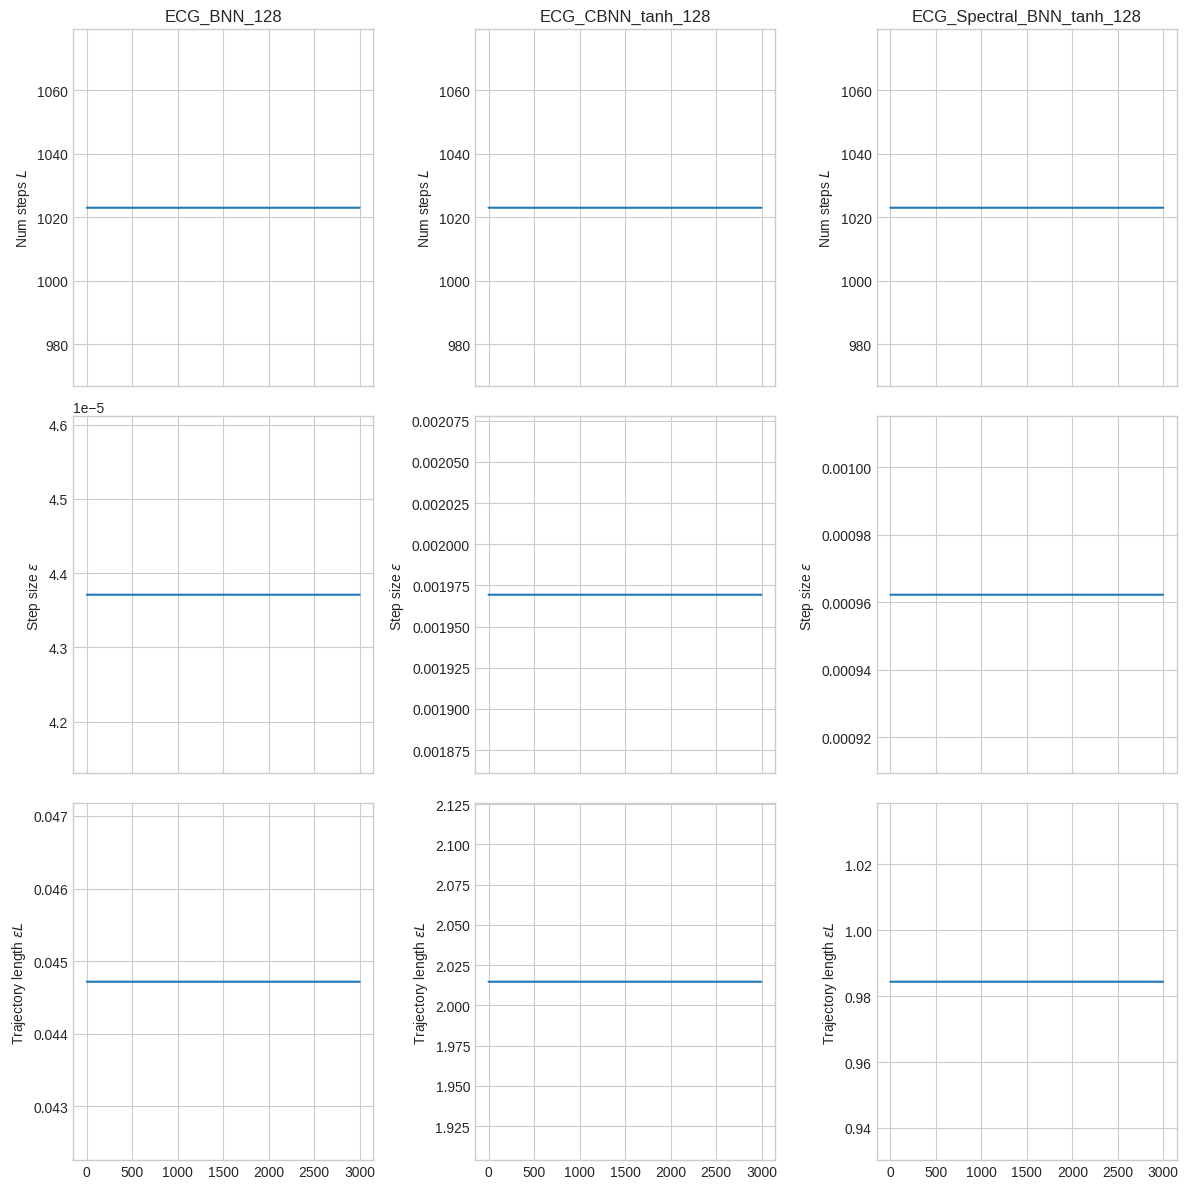

In [9]:
fig, axs = plt.subplots(ncols=len(samples), nrows=3, figsize=(3*4, 3*4), sharex=True, sharey=False)
for i, sample in enumerate(samples):
    if sample["method"] == "SVI":
        continue
    axs[0,i].plot(samples[i]["num_steps"])
    axs[0,i].set_ylabel("Num steps $L$")
    axs[1,i].plot(samples[i]["step_size"])
    axs[1,i].set_ylabel("Step size $\epsilon$")
    axs[2,i].plot(samples[i]["num_steps"] * samples[i]["step_size"])
    axs[2,i].set_ylabel("Trajectory length $\epsilon L$")
    axs[0,i].set_title(samples[i]["model"])

fig.tight_layout()
    

In [6]:
#samples[1]["model"]
from sklearn.utils import resample
X = dataset.normalize_X(dataset.X, dataset.splits[0])
X_test = X[dataset.splits[0]["te"]]
y_test = dataset.y[dataset.splits[0]["te"]]
X_test, y_test = resample(X_test, y_test, n_samples=500, random_state=SEED)

def nll_histogram(model, post_draws, X, y, batch_ndims):
    batch_size = min(5120, X.shape[0])
    n_batches = X.shape[0] // batch_size + 1 if X.shape[0] > 5120 else 1
    nlls = []
    densities = []

    for i in range(n_batches):
        start = i * batch_size
        end = max((i + 1) * batch_size, X.shape[0] - 1)
        nll = log_likelihood(model, post_draws, X[start:end], y[start:end], prior_probs=None, batch_ndims=batch_ndims)["y"]
        density, _ = log_density(model, model_args=(X[start:end], y[start:end]), model_kwargs={"prior_probs": None}, params=post_draws)
        #nll = jax.scipy.special.logsumexp(nll, axis=-2) - jnp.log(nll.shape[-2])
        if batch_ndims == 2:
            nll = jax.scipy.special.logsumexp(nll, axis=-2).astype(jnp.float64) - jnp.log(nll.shape[-2])
        nlls.append(nll)
        densities.append(density - nll)
    nlls = jnp.concat(nlls, axis=-1)
    nlls = jax.scipy.special.logsumexp(nlls, axis=-2)
    return -nlls.astype(jnp.float64)

def plot_nll_histogram(model, post_draws, X, y, batch_ndims):
    nlls = nll_histogram(model, post_draws, X, y, batch_ndims)
    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
    sns.histplot(nlls, bins=50, kde=True, ax=axs[0])
    axs[0].set_xlabel("Negative log likelihood")
    axs[0].set_ylabel("Density")
    axs[0].set_title("Histogram of negative log likelihood")
    axs[1].set_xlabel("Negative log prior density")
    axs[1].set_ylabel("Density")
    axs[1].set_title("Histogram of negative log prior density")
    plt.show()

sample_dict = samples[1]
model = getattr(bnns.model_configs, sample_dict["model"])
post_draws = sample_dict["post_draws"]
batch_ndims = 1 if sample_dict["method"] == "SVI" else 2
split = dataset.splits[int(sample_dict["split"])]
plot_nll_histogram(model, post_draws, X_test, y_test, batch_ndims)

ValueError: Incompatible shapes for broadcasting: shapes=[(3000, 3), (187,)]

In [39]:
def forward_pass_BNN(post_draws, X, s=0):
    w0 = post_draws["w0"][0, s]
    b0 = post_draws["b0"][0, s]
    w1 = post_draws["w1"][0, s]
    b1 = post_draws["b1"][0, s]
    w2 = post_draws["w2"][0, s]
    b2 = post_draws["b2"][0, s]
    w3 = post_draws["w3"][0, s]
    b3 = post_draws["b3"][0, s]

    z0 = jax.nn.tanh(jnp.dot(X, w0) + b0)
    z1 = jax.nn.tanh(jnp.dot(z0, w1) + b1)
    z2 = jax.nn.tanh(jnp.dot(z1, w2) + b2)
    z3 = jnp.dot(z2, w3) + b3

    return z3


def forward_pass_CBNN(post_draws, X, s=0):
    w0 = post_draws["w0"][0, s]
    b0 = post_draws["b0"][0, s]
    w1 = post_draws["w1"][0, s]
    b1 = post_draws["b1"][0, s]
    w2 = post_draws["w2"][0, s]
    b2 = post_draws["b2"][0, s]
    w3 = post_draws["w3"][0, s]
    b3 = post_draws["b3"][0, s]

    z0 = jax.nn.tanh(jnp.real(jnp.fft.ifft(jnp.fft.fft(w0) * jnp.fft.fft(X))[:, :128]) + b0)
    z1 = jax.nn.tanh(jnp.real(jnp.fft.ifft(jnp.fft.fft(w1) * jnp.fft.fft(z0))) + b1)
    z2 = jax.nn.tanh(jnp.real(jnp.fft.ifft(jnp.fft.fft(w2) * jnp.fft.fft(z1))) + b2)
    z3 = jnp.dot(z2, w3) + b3

    return z3

grad_bnn = jax.block_until_ready(jax.jit(jax.jacobian(forward_pass_BNN, argnums=0)))
grad_cbnn = jax.block_until_ready(jax.jit(jax.jacobian(forward_pass_CBNN, argnums=0)))

X = dataset.normalize_X(dataset.X, dataset.splits[0])
example_X = X[0:1]
example_y = dataset.y[0:1]
#forward_pass_BNN(samples[0]["post_draws"], example_X, s=0)
print("time, BNN:")
%time grad = jax.block_until_ready(grad_bnn(samples[0]["post_draws"], example_X, s=1500))
print("time, CBNN:")
%time grad = jax.block_until_ready(grad_cbnn(samples[1]["post_draws"], example_X, s=1500))



time, BNN:
CPU times: user 1.83 s, sys: 2.53 s, total: 4.35 s
Wall time: 1.18 s
time, CBNN:
CPU times: user 709 ms, sys: 354 ms, total: 1.06 s
Wall time: 530 ms


In [39]:
log_density(getattr(bnns.model_configs, "ECG_BNN_128"), model_args=[], model_kwargs={"X": example_X, "y": example_y, "prior_probs": None}, params=samples[0]["post_draws"])

AssertionError: Shapes z: (1, 3000, 3000, 5)

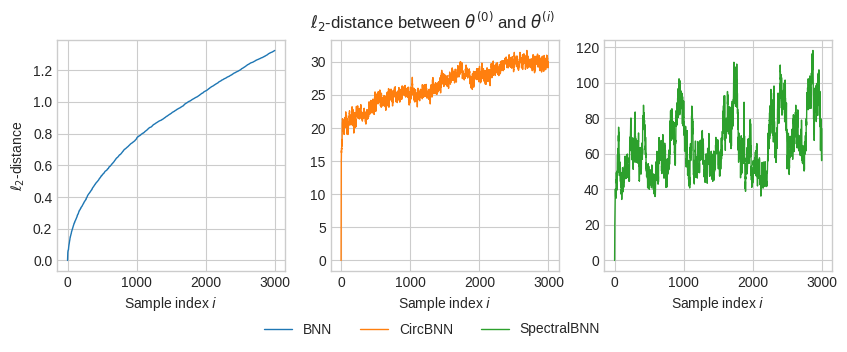

In [16]:
distances = []
for i in range(0, 3000 - 1):
    sample_dict = samples[0]
    #flattened_post_draws = 
    sample1 = jnp.concat([jnp.reshape(value[0, 0], (-1,)) for key, value in sample_dict["post_draws"].items()], axis=0)
    sample2 = jnp.concat([jnp.reshape(value[0, i], (-1,)) for key, value in sample_dict["post_draws"].items()], axis=0)
    bnn = jnp.linalg.norm(sample1 - sample2)

    sample_dict = samples[1]
    sample1 = jnp.concat([jnp.reshape(value[0, 0], (-1,)) for key, value in sample_dict["post_draws"].items()], axis=0)
    sample2 = jnp.concat([jnp.reshape(value[0, i], (-1,)) for key, value in sample_dict["post_draws"].items()], axis=0)
    circbnn = jnp.linalg.norm(sample1 - sample2)

    sample_dict = samples[2]
    sample1 = jnp.concat([jnp.reshape(value[0, 0], (-1,)) for key, value in sample_dict["post_draws"].items()], axis=0)
    sample2 = jnp.concat([jnp.reshape(value[0, i], (-1,)) for key, value in sample_dict["post_draws"].items()], axis=0)
    spectralbnn = jnp.linalg.norm(sample1 - sample2)

    distances.append({
        "BNN": bnn,
        "CircBNN": circbnn,
        "SpectralBNN": spectralbnn
    })
distances = pd.DataFrame(distances)
fig, axs = plt.subplots(ncols=3, figsize=(10, 3))
axs[0].plot(distances["BNN"], label="BNN", color="C0", linewidth=1)
axs[1].plot(distances["CircBNN"], label="CircBNN", color="C1", linewidth=1)
axs[2].plot(distances["SpectralBNN"], label="SpectralBNN", color="C2", linewidth=1)
fig.suptitle(r"$\ell_2$-distance between $\theta^{(0)}$ and $\theta^{(i)}$")
axs[0].set_xlabel("Sample index $i$")
axs[1].set_xlabel("Sample index $i$")
axs[2].set_xlabel("Sample index $i$")
axs[0].set_ylabel(r"$\ell_2$-distance")
h0, l0 = axs[0].get_legend_handles_labels()
h1, l1 = axs[1].get_legend_handles_labels()
h2, l2 = axs[2].get_legend_handles_labels()
fig.legend(h0 + h1 + h2, l0 + l1 + l2, title="", loc="lower center", bbox_to_anchor=(0.50, -0.15), ncol=3, frameon=False)

In [11]:
jnp.linalg.norm(samples[0]["post_draws"]["w0"][0, 0] - samples[0]["post_draws"]["w0"][0, -1])

Array(0.8531463, dtype=float32)

In [8]:
def count_latent_variables(sample_dict):
    post_draws = sample_dict["post_draws"]
    model_name = sample_dict["model"]
    num_variables = 0
    for key, value in post_draws.items():
        num_variables += value.size
    print(f"{model_name} has {num_variables} variables")
count_latent_variables(samples[0])
count_latent_variables(samples[1])

ECG_BNN_128 has 173199000 variables
ECG_CBNN_tanh_128 has 4416000 variables


In [21]:
from numpyro.diagnostics import print_summary, summary
summary(samples[1]["post_draws"])

{'b0': OrderedDict([('mean',
               array([ 1.7909853 , -0.33849302,  1.5692701 ,  2.5820167 , -2.7587237 ,
                       0.18957603,  1.6280981 ,  0.39244938, -3.289401  ,  3.337078  ,
                       1.680599  , -2.3567169 ,  3.9854453 , -0.97184134,  3.668431  ,
                      -4.669019  ,  1.3855282 ,  0.7588421 , -0.54223263, -0.03724635,
                       1.8890259 , -0.02429267, -1.4644696 , -1.377854  ,  2.0252898 ,
                       1.2568973 , -0.28194058,  2.8422701 , -3.058949  , -2.4225452 ,
                       0.336591  ,  0.77045083,  0.84102523,  1.5023888 ,  0.90534353,
                       1.6835755 ,  0.8591556 , -1.8142928 ,  0.86231023, -0.2611371 ,
                       1.680291  , -2.7407238 ,  0.5742709 ,  0.89941275, -3.6301768 ,
                      -0.3996326 ,  0.20383419, -1.2594532 ,  1.4553955 , -0.9284843 ,
                       1.2946583 ,  1.1871713 , -0.20792761,  1.2107543 , -0.2690003 ,
              